# Automatic differentiation for non-differentiable functions

How can we automatically generate derivative-like information for non-differentiable functions in a manner analogous to automatic differentiation for smooth functions?

ForwardDiff.jl package works nicely for differentiable functions:

In [1]:
using ForwardDiff

In [2]:
x = 1.0;
smoothFun(x) = x^2
g1 = x -> ForwardDiff.derivative(smoothFun, x);
g1(x)

2.0

But what about for a nondifferentiable function?

In [3]:
maxFun(x) = max(x,x^2);
g2 = x -> ForwardDiff.derivative(maxFun, x);
g2(x)

2.0

In [4]:
maxFun2(x) = max(x^2,x);
g3 = x -> ForwardDiff.derivative(maxFun2, x);
g3(x)

1.0

## Automatic computation of lexicographic directional (LD) derivatives

We can solve this problem by using "lexicographic directional derivatives" instead of classical directional derivatives and defining the "rules" for elemental nonsmooth functions.     

In brief, the LD-derivative takes as an argument an $n$ dimensional vector and a nonsingular $n\times p$ direction matrix:    
Classic directional derivative: $\mathbf{f}'(\mathbf{x},\mathbf{d}_0)$, with $\mathbf{x},\mathbf{d}_0 \in \mathbb{R}^n$    
Lexicographic directional derivative: $\mathbf{f}'(\mathbf{x},\mathbf{M})$, with $\mathbf{M} = [\mathbf{d}_0 \; \mathbf{d}_1 ... \mathbf{d}_p]\in \mathbb{R}^{n \times p}$, $\text{det}(\mathbf{M})\neq 0$.  

LD-derivative calculations consider a sequence of directions to resolve a generalized derivative at points of nonsmoothness.

In [5]:
type ldouble{T<:Real,U<:Integer}
    value::T
    dot::Vector{T}
    depth::U
    ldouble(x,dot,depth) = length(dot) == depth ? new(x,dot,depth) : error("Inconsistent depth!");
end

In [6]:
## Constructors
ldouble() = ldouble(0.0,Vector{Float64}(0),0);
ldouble{U<:Integer}(depth::U) = ldouble(0.0, zeros(Float64,depth),depth);
ldouble{T<:Real,U<:Integer}(x::T,depth::U) = ldouble(x,zeros(T,depth),depth);
ldouble{T<:Real,U<:Integer}(x::T,dot::Vector{T},depth::U) = ldouble{T,U}(x,dot,depth);

The LD-derivative is a generalization of the directional derivative that obeys a sharp chain rule.  
This means that all smooth functions can be differentiated exactly as in the case of classic AD.

In [7]:
## Operator overloads

## Display
import Base.show
function show(io::IO, zA::ldouble)
    print(io, zA.value, " ", zA.dot);
end

## Negation
import Base.- 
function -(zA::ldouble)
    zOut = ldouble(zA.depth);
    zOut.value = (-zA.value);
    zOut.dot = -zA.dot;
    return zOut;
end

## Addition
import Base.+
function +(zA::ldouble,x::Real) 
    zOut = ldouble(zA.depth);
    zOut.value = zA.value + x;
    zOut.dot = zA.dot;
    return zOut;
end

import Base.+
function +(x::Real,zA::ldouble) 
    return zA+x;
end

import Base.+
function +(zA::ldouble,zB::ldouble) 
    if (zA.depth == 0 && zB.depth > 0) 
        return zA.value + zB;
    end
    if (zA.depth > 0 && zB.depth == 0) 
        return zA + zB.value;
    end
    
    assert(zA.depth == zB.depth);
    zOut = ldouble(zA.depth);
    zOut.value = zA.value+zB.value;
    zOut.dot = zA.dot + zB.dot;
    
    return zOut;
end

## Subtraction

import Base.-
function -(zA::ldouble,x::Real) 
    zOut = ldouble(zA.depth);
    zOut.value = zA.value - x;
    zOut.dot = zA.dot;
    return zOut;
end

import Base.-
function -(x::Real,zA::ldouble) 
    return -(zA-x);
end

import Base.-
function -(zA::ldouble,zB::ldouble) 
    if (zA.depth == 0 && zB.depth > 0) 
        return zA.value - zB;
    end
    if (zA.depth > 0 && zB.depth == 0) 
        return zA - zB.value;
    end
    
    assert(zA.depth == zB.depth);
    zOut = ldouble(zA.depth);
    zOut.value = zA.value - zB.value;
    zOut.dot = zA.dot - zB.dot;
    
    return zOut;
end

## Multiply

import Base.*
function *(zA::ldouble,x::Real) 
    zOut = ldouble(zA.depth);
    zOut.value = zA.value * x;
    zOut.dot = x*zA.dot;
    return zOut;
end

import Base.*
function *(x::Real,zA::ldouble) 
    return zA*x;
end

import Base.*
function *(zA::ldouble,zB::ldouble) 
    if (zA.depth == 0 && zB.depth > 0) 
        return zA.value * zB;
    end
    if (zA.depth > 0 && zB.depth == 0) 
        return zA * zB.value;
    end
    
    assert(zA.depth == zB.depth);
    zOut = ldouble(zA.depth);
    zOut.value = zA.value * zB.value;
    for i = 1:zA.depth
        zOut.dot[i] = zA.dot[i]*zB.value + zA.value*zB.dot[i];
    end
    
    return zOut;
end

## Divide

import Base./
function /(zA::ldouble,x::Real) 
    assert(x!=0.0);
    zOut = ldouble(zA.depth);
    zOut.value = zA.value / x;
    zOut.dot = zA.dot/x;
    return zOut;
end

import Base./
function /(x::Real,zA::ldouble) 
    if zA.value != 0.0
        zOut = ldouble(zA.depth);
        zOut.value = x/zA.value;
        for i = 1:zA.depth
            zOut.dot[i] = x*(-zA.dot[i])/(zA.value*zA.value);
        end
    else
        error("Attempt to divide by zero!");
    end
    
    return zOut;
end

import Base./
function /(zA::ldouble,zB::ldouble) 
    return zA * (1.0/zB);
end

## Exp
import Base.exp
function exp(zA::ldouble) 
    zOut = ldouble(zA.depth);
    zOut.value = exp(zA.value);
    for i = 1:zA.depth
        zOut.dot[i] = zA.dot[i]*zOut.value;
    end 
    return zOut;
end

exp (generic function with 14 methods)

The nonsmooth elemental functions are more involved.  

For example, the absolute value function generalized derivatives are given by:        
Set $s_1 \leftarrow \text{sign}(x)$    
$\textbf{for } k=1:p$    
$\quad \textbf{if } s_1 = 0$     
$\quad \quad s_1 \leftarrow \text{sign}(m_{(k)})$      
$\quad \textbf{end } $     
$\quad \text{Set } \dot{v}_{(k)} \leftarrow s_1m_{(k)}$     
$\textbf{end }$   

Code below implements: abs($\cdot$), max($\cdot$,$\cdot$), min($\cdot$,$\cdot$), mid($\cdot$,$\cdot$,$\cdot$), $||(\cdot,\cdot)||_2$ for relevant combinations of ldouble and real number objects.

In [8]:
## Nonsmooth functions
import Base.abs
function abs(zA::ldouble)
    zOut = ldouble(zA.depth);
    zOut.value = abs(zA.value);
    s = (0.0 < zA.value) - (zA.value < 0.0);
    for i = 1:zA.depth
        if (s==0)
            s = (0.0 < zA.dot[i]) - (zA.dot[i] < 0.0);
        end
        zOut.dot[i] = s*zA.dot[i];
    end
    return zOut;
end

import Base.max
function max(zA::ldouble, x::Real)
    zOut = ldouble(zA.depth);
    zOut.value = max(zA.value, x);
    s = (x < zA.value) - (zA.value < x);
    for i = 1:zA.depth
        if (s==0)
            s = (0.0 < zA.dot[i]) - (zA.dot[i] < 0.0);
        end
        if (s >= 0)
            zOut.dot[i] = zA.dot[i];
        else
            zOut.dot[i] = 0.0;
        end
    end
    return zOut;
end

import Base.max
function max(x::Real,zA::ldouble)
    return max(zA,x);
end

import Base.max
function max(zA::ldouble, zB::ldouble)
    if (zA.depth == 0 && zB.depth > 0) 
        return max(zA.value,zB);
    end
    if (zA.depth > 0 && zB.depth == 0) 
        return max(zA,zB.value);
    end
    assert(zA.depth == zB.depth);
    zOut = ldouble(zA.depth);
    zOut.value = max(zA.value, zB.value);
    s = (zB.value < zA.value) - (zA.value < zB.value);
    for i = 1:zA.depth
        if (s==0)
            s = (zB.dot[i] < zA.dot[i]) - (zA.dot[i] < zB.dot[i]);
        end
        if (s >= 0)
            zOut.dot[i] = zA.dot[i];
        else
            zOut.dot[i] = zB.dot[i];
        end
    end
    return zOut;
end

import Base.min
function min(zA::ldouble, x::Real)
    zOut = ldouble(zA.depth);
    zOut.value = min(zA.value, x);
    s = (x < zA.value) - (zA.value < x);
    for i = 1:zA.depth
        if (s==0)
            s = (0.0 < zA.dot[i]) - (zA.dot[i] < 0.0);
        end
        if (s <= 0)
            zOut.dot[i] = zA.dot[i];
        else
            zOut.dot[i] = 0.0;
        end
    end
    return zOut;
end

import Base.min
function min(x::Real,zA::ldouble)
    return min(zA,x);
end

import Base.min
function min(zA::ldouble, zB::ldouble)
    if (zA.depth == 0 && zB.depth > 0) 
        return min(zA.value,zB);
    end
    if (zA.depth > 0 && zB.depth == 0) 
        return min(zA,zB.value);
    end
    assert(zA.depth == zB.depth);
    zOut = ldouble(zA.depth);
    zOut.value = min(zA.value, zB.value);
    s = (zB.value < zA.value) - (zA.value < zB.value);
    for i = 1:zA.depth
        if (s==0)
            s = (zB.dot[i] < zA.dot[i]) - (zA.dot[i] < zB.dot[i]);
        end
        if (s <= 0)
            zOut.dot[i] = zA.dot[i];
        else
            zOut.dot[i] = zB.dot[i];
        end
    end
    return zOut;
end

function mid{T,U,V}(zA::T, zB::U, zC::V)
    return max(min(zA,zB),min(max(zA,zB),zC));
end

function twonorm(zA::ldouble, x::Real)
    zOut = ldouble(zA.depth);
    zOut.value = sqrt(zA.value*zA.value + x*x);
    if zOut.value != 0.0
        zAunitV = zA.value/zOut.value;
        for i = 1:zA.depth
            zOut.dot[i] = zAunitV*zA.dot[i];
        end
    else
        mjAunitV = 0.0;
        for i = 1:zA.depth
            if mjAunitV == 0.0
                mjAunitV = (0.0 < zA.dot[i]) - (zA.dot[i] < 0.0);
            end
            if mjAunitV != 0.0
                zOut.dot[i] = mjAunitV*zA.dot[i];
            else
                zOut.dot[i] = 0.0;
            end
        end
    end    
    return zOut;
end

function twonorm(x::Real, zA::ldouble)
    return twonorm(zA,x);
end

function twonorm(zA::ldouble, zB::ldouble)
    if (zA.depth == 0 && zB.depth > 0) 
        return twonorm(zA.value,zB);
    end
    if (zA.depth > 0 && zB.depth == 0) 
        return twonorm(zA,zB.value);
    end
    assert(zA.depth == zB.depth);
    zOut = ldouble(zA.depth);
    zOut.value = sqrt(zA.value*zA.value + zB.value*zB.value);
    if zOut.value != 0.0
        zAunitV = zA.value/zOut.value;
        zBunitV = zB.vlaue/zOut.value;
        for i = 1:zA.depth
            zOut.dot[i] = zAunitV*zA.dot[i]+zBunitV*zB.dot[i];
        end
    else
        mjNorm = 0.0; mjAunitV = 0.0; mjBunitV = 0.0;
        for i = 1:zA.depth
            if mjNorm == 0.0
                mjNorm = sqrt(zA.dot[i]*zA.dot[i]+zB.dot[i]*zB.dot[i]);
                if mjNorm > 0.0
                    mjAunitV = zA.dot[i]/mjNorm;
                    mjBunitV = zB.dot[i]/mjNorm;
                end
            end
            if mjNorm != 0.0
                zOut.dot[i] = mjAunitV*zA.dot[i]+mjBunitV*zB.dot[i];
            else
                zOut.dot[i] = 0.0;
            end
        end
    end    
    return zOut;
end

twonorm (generic function with 3 methods)

## Arithmetic and nonsmooth function tests

In [9]:
zA = ldouble(1.7,[-1.0, -1.0, -1.0], 3)

1.7 [-1.0,-1.0,-1.0]

In [10]:
zB = ldouble(5.0, [-3.0, 2.0, 3.0], 3)

5.0 [-3.0,2.0,3.0]

In [11]:
x = 2.3;

In [12]:
-zA

-1.7 [1.0,1.0,1.0]

In [13]:
zA+zB

6.7 [-4.0,1.0,2.0]

In [14]:
zA+x

4.0 [-1.0,-1.0,-1.0]

In [15]:
x+zB

7.3 [-3.0,2.0,3.0]

In [16]:
zA*zB

8.5 [-10.1,-1.6,0.1]

In [17]:
zA*x

3.9099999999999997 [-2.3,-2.3,-2.3]

In [18]:
x*zB

11.5 [-6.9,4.6,6.9]

In [19]:
zA-zB

-3.3 [2.0,-3.0,-4.0]

In [20]:
zA-x

-0.5999999999999999 [-1.0,-1.0,-1.0]

In [21]:
x-zB

-2.7 [3.0,-2.0,-3.0]

In [22]:
zA/zB

0.34 [0.004,-0.336,-0.404]

In [23]:
zA/x

0.7391304347826088 [-0.434783,-0.434783,-0.434783]

In [24]:
x/zB

0.45999999999999996 [0.276,-0.184,-0.276]

In [25]:
zC = ldouble(0.0,[0.0,-2.0,3.0], 3)

0.0 [0.0,-2.0,3.0]

In [26]:
zD = ldouble(0.0,[0.0,-2.0,4.0],3)

0.0 [0.0,-2.0,4.0]

In [27]:
y = 0.0;

In [28]:
abs(zC)

0.0 [0.0,2.0,-3.0]

In [29]:
max(zC,zD)

0.0 [0.0,-2.0,4.0]

In [30]:
max(zC,y)

0.0 [0.0,0.0,0.0]

In [31]:
max(y,zD)

0.0 [0.0,0.0,0.0]

In [32]:
min(zC,zD)

0.0 [0.0,-2.0,3.0]

In [33]:
min(zC,y)

0.0 [0.0,-2.0,3.0]

In [34]:
min(y,zD)

0.0 [0.0,-2.0,4.0]

In [35]:
mid(zC,zD,y)

0.0 [0.0,-2.0,4.0]

In [36]:
h(x,y,z) = x+y+z-max(max(x,y),z)-min(min(x,y),z);

In [37]:
h(zC,zD,y)

0.0 [0.0,-2.0,4.0]

In [38]:
twonorm(zC,zD)

0.0 [0.0,2.82843,-4.94975]

In [39]:
twonorm(zC,y)

0.0 [0.0,2.0,-3.0]

In [40]:
twonorm(y,zD)

0.0 [0.0,2.0,-4.0]

## Solving nonsmooth equations with LD-derivatives

Suppose we want to find the zeros of the following function:    
\begin{align*}
\mathbf{f}:\mathbb{R}^2\times\mathbb{R}^2\rightarrow\mathbb{R}^2 : (\mathbf{x,p}) \mapsto  \left[ 
  \begin{array}{l l}
   p_1x_2 + \text{abs}(x_1+x_2)\text{max}(x_1,x_2)\\
   x_2+p_2x_1\text{min}(\text{max}(x_1,x_2),x_1)
  \end{array} \right],
\end{align*}

with parameter values $\mathbf{p} = [2.0, 1.0]$.


In [41]:
function f{T,U}(x::Vector{T}, p::Vector{U}, y::Vector{T})
    
    y[1] = p[1]*x[2] + max(x[1],x[2])*abs(x[1]+x[2]);
    y[2] = x[2]+p[2]*x[1]*min(max(x[1],x[2]),x[1]);
    
end

f (generic function with 1 method)

The simplest way to do this is with the semismooth Newton method.     
This is essentially identical to the classical Newton method, except the Newton step is defined as:    
\begin{equation}
\mathbf{G}(\mathbf{x}^k)(\mathbf{x}^{k+1}-\mathbf{x}^k)=-\mathbf{f}(\mathbf{x}^k),   
\end{equation}
where $\mathbf{G}(\mathbf{x}^k)$ is an element of a generalized derivative of $\mathbf{f}$ at $\mathbf{x}^k$. 

We can generate a generalized derivative with desirable convergence properties by setting:
\begin{equation}
\mathbf{G}(\mathbf{x}^k):=\mathbf{f}'(\mathbf{x}^k;\mathbf{I}),
\end{equation}
where $\mathbf{I}$ is the $n\times n$ identity matrix.

In [42]:
function semismoothNewton{T<:Real}(x::Vector{T}, p::Vector{T}, usr_fun::Function, maxIt::Integer, eTol::Real)
    
    ## Preallocation
    nVar = length(x);
    y = Vector{T}(nVar);
    ldX = Vector{ldouble}(nVar);
    ldY = Vector{ldouble}(nVar);
    genDeriv = Matrix{Real}(nVar,nVar);
    maxNorm = 2.0*eTol;
    nIter = 0;
    convdata = Array{Real}(0,2);
    
    ## Main solver loop
    while (maxNorm >= eTol && nIter < maxIt)
        nIter += 1;
        
        ## Initialize Ldoubles with direction matrix as the identity matrix in nVar × nVar space
        for i=1:nVar
            ldX[i] = ldouble(nVar);
            ldX[i].value = x[i];
            for j = 1:nVar
                ldX[i].dot[j] = 0.0;
            end
            ldX[i].dot[i] = 1.0;
        end

        ## Call user defined function
        usr_fun(ldX,p,ldY);

        ## Unpack residual, generalized derivative element and calculate error
        maxNorm = 0.0;
        for i=1:nVar
            y[i] = ldY[i].value;
            maxNorm = max(maxNorm,abs(y[i]));
            for j = 1:nVar
                genDeriv[i,j] = ldY[i].dot[j];
            end
        end
        
        ## Print and store iteration statistics
        println("Iter ", nIter, ": ||f(x)|| = ", maxNorm);
        convdata = [convdata; nIter maxNorm];
        
        ## Take Newton step if needed
        if (maxNorm >= eTol)
            d = genDeriv\y;
            x -= d;
        end
        
    end
    
    if (maxNorm < eTol && nIter <= maxIt)
        println("Solution: ", x,  ", Residual value: ", y)
        return true, convdata;
    end
    
    println("Solution not found!")
    return false, convdata;
end

semismoothNewton (generic function with 1 method)

In [61]:
x = [3.0,3.0]; p = [2.0,1.0]; 
status, SSconvdata = semismoothNewton(x,p,f,50,1.0e-9);

Iter 1: ||f(x)|| = 24.0
Iter 2: ||f(x)|| = 5.877551020408163
Iter 3: ||f(x)|| = 1.3541877551020405
Iter 4: ||f(x)|| = 0.2472544205707181
Iter 5: ||f(x)|| = 0.020453123731630107
Iter 6: ||f(x)|| = 0.00020094522028321754
Iter 7: ||f(x)|| = 2.018138007374142e-8
Iter 8: ||f(x)|| = 2.0364404829940559e-16
Solution: [-3.54198e-16,1.01822e-16], Residual value: [2.03644e-16,1.01822e-16]


For particular types of generalized derivatives, this method will converge quadratically in a local neighborhood of the solution. For the types of functions above (piecewise-differentiable functions), LD-derivatives evaluated with the identity direction matrix satisfy the necessary properties.

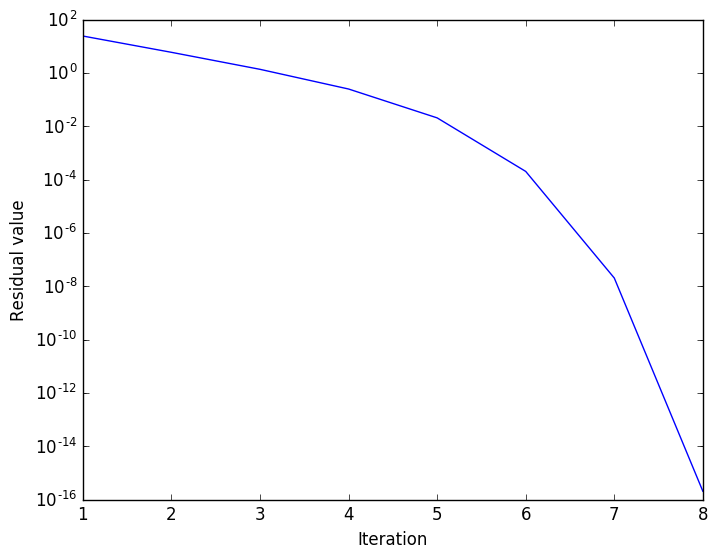

In [44]:
using PyPlot;
semilogy(SSconvdata[:,1],SSconvdata[:,2])
xlabel("Iteration");
ylabel("Residual value");
xticks(SSconvdata[:,1]);

In [62]:
x2 = [4.0, -5.0]; p = [2.0,1.0];
semismoothNewton(x2,p,f,50,1.0e-9);

Iter 1: ||f(x)|| = 11.0
Iter 2: ||f(x)|| = 2.9349112426035493
Iter 3: ||f(x)|| = 1.1476936239800857
Iter 4: ||f(x)|| = 0.06393928408497018
Iter 5: ||f(x)|| = 0.00024900855904874675
Iter 6: ||f(x)|| = 3.775141976802843e-9
Iter 7: ||f(x)|| = 3.552713678800501e-15
Solution: [3.0,-9.0], Residual value: [-3.55271e-15,0.0]


## Was all this LD-derivative calculation actually necessary? 
Could we have used a less convoluted definition of the generalized derivative?

In the previous example, assembling a derivative by concatenating directional derivatives in the coordinate directions may have worked (this was the only way before LD-derivatives).        

However, this example shows that this does NOT work for all nonsmooth functions.
\begin{align*}
\mathbf{g}:\mathbb{R}^2\rightarrow\mathbb{R}^2 : \mathbf{x} \mapsto  \left[ 
  \begin{array}{l l}
   \text{min}(2x_1 - 2x_2, x_1)/3\\
   \text{max}(2x_2 - 2x_1, x_2)/3
  \end{array} \right]
\end{align*}

In [63]:
function g{T,U}(x::Vector{T}, p::Vector{U}, y::Vector{T})
       
    y[1] = 1/3*min(2*x[1] - 2*x[2], x[1]);
    y[2] = 1/3*max(2*x[2] - 2*x[1], x[2]);
    
    return;
end

g (generic function with 1 method)

{#T<:Any, 1}, Array{#U<:Any, 1}, Array{#T<:Any, 1}) in module Main at In[46]:3 overwritten at In[63]:3.


In [64]:
x3 = [2.0,1.0];
semismoothNewton(x3,p,g,50,1.0e-9);

Iter 1: ||f(x)|| = 0.6666666666666666
Iter 2: ||f(x)|| = 0.0
Solution: Real[0.0,0.0], Residual value: [0.0,0.0]


So the semismooth Newton method solves this in one iteration. Now, say we assemble the following generalized derviative:
\begin{equation}
\hat{\mathbf{J}}\mathbf{g}(\mathbf{x}):=[\mathbf{g}'(\mathbf{x}^k;\mathbf{e}_1) \; \; \mathbf{g}'(\mathbf{x};\mathbf{e}_2)] \neq \mathbf{g}'(\mathbf{x}^k;\mathbf{I})
\end{equation}


In [48]:
function dumbNewton{T<:Real}(x::Vector{T}, p::Vector{T}, usr_fun::Function, maxIt::Integer, eTol::Real)
    
    ## Preallocation
    nVar = length(x);
    y = Vector{T}(nVar);
    ldX = Vector{ldouble}(nVar);
    ldY = Vector{ldouble}(nVar);
    genDeriv = Matrix{Real}(nVar,nVar);
    maxNorm = 2.0*eTol;
    nIter = 0;
    
    ## Begin main solver loop
    while (maxNorm >= eTol && nIter < maxIt)
        nIter += 1;
        
        ## Set up depth-one derivatives
        for i=1:nVar
            ldX[i] = ldouble(1);
            ldX[i].value = x[i];
        end
        
        ## Evalaute the function nVar times with each coordinate vector and assemble pseudo-Jacobian
        for k = 1:nVar
            for i = 1:nVar
                ldX[i].dot[1] = 0.0
                if (k == i)
                    ldX[k].dot[1] = 1.0;
                end
            end
  
            usr_fun(ldX,p,ldY);

            for i = 1:nVar
                genDeriv[i,k] = ldY[i].dot[1];
            end
        end
        
        maxNorm = 0.0;
        for i=1:nVar
            y[i] = ldY[i].value;
            maxNorm = max(maxNorm,abs(y[i]));
        end

        println("Iter ", nIter, ": ||f(x)|| = ", maxNorm);
        
        ## Take Newton step if needed
        if (maxNorm >= eTol)
            d = genDeriv\y;
            x -= d;
        end
        
    end
    
    if (maxNorm < eTol && nIter <= maxIt)
        println("Solution: ", x,  ", Residual value: ", y)
        return true;
    end
    
    println("Solution not found!")
    return false;
end

dumbNewton (generic function with 1 method)

In [65]:
x3 = [2.0,1.0]; 
dumbNewton(x3,p,g,50,1.0e-9);

Iter 1: ||f(x)|| = 0.6666666666666666
Iter 2: ||f(x)|| = 1.3333333333333333


LoadError: LoadError: Base.LinAlg.SingularException(2)
while loading In[65], in expression starting on line 2

Here, the Newton step has taken us to a point with a singular pesudo-Jacobian and the method fails.  

## A more robust Newton-type method

Suppose we want to solve the optimization problem:
\begin{align}
\underset{\mathbf{x}}{\text{min}} \; &(x_1+x_2)x_4+0.5(x_2+x_3)^2 \\
\text{s.t} \; &x_1 \leq 0 \\
&x_1 \geq 0 \\
&x_2 \geq 1 \\
&x_4 \geq 0 \\
&x_1+x_2+x_3 \geq 0.  
\end{align}
We'll do this by setting up and solving the associated nonsmooth system of equations defining its KKT points.

In [50]:
function KKTsys{T,U}(x::Vector{T}, p::Vector{U},y::Vector{T})
    
    z = x[1:4]; u = x[5:9]; v = x[10:14];
    
    y[1] = z[4] + u[1] - u[2] - u[5];
    y[2] = x[4] + x[2] + x[3] - u[3] - u[5];
    y[3] = x[2] + x[3] - u[5];
    y[4] = x[1] + x[2] - u[4];
    y[5] = x[1] + v[1];
    y[6] = -x[1] + v[2];
    y[7] = 1 - x[2] + v[3];
    y[8] = -x[4] + v[4];
    y[9] = -x[1] - x[2] - x[3] + v[5];
    for i = 1:5
        y[9+i] = min(u[i],v[i]);
    end
    
end

KKTsys (generic function with 1 method)

In [51]:
x0 = [1.0,4.0,-2.0,1.0,3.0,3.0,1.0,4.0,1.0,0.0,1.0,3.0,1.0,3.0];
semismoothNewton(x0,p,KKTsys,50,1.0e-9);

Iter 1: ||f(x)|| = 1.0


LoadError: LoadError: Base.LinAlg.SingularException(6)
while loading In[51], in expression starting on line 2

Oh no! The semismooth Newton method failed because it encountered a singular generalized derivative, even when using LD-derivatives.    

Luckily, there is another method we can use. It is called the LP Newton method, wherein the linear solve step of the Newton method is replaced a linear program solve:

\begin{align}
\underset{ \gamma, \mathbf{x}}{\text{min}}
\; &\gamma \\
\text{s.t. }
& ||\mathbf{f}(\mathbf{x}^k)+ \mathbf{G}(\mathbf{x}^k)(\mathbf{x} - \mathbf{x}^k)||_\infty \leq \gamma\text{min}\left(||\mathbf{f}(\mathbf{x}^k)||_\infty,||\mathbf{f}(\mathbf{x}^k)||_\infty^2\right), \\
& ||(\mathbf{x} - \mathbf{x}^k)||_\infty \leq \gamma||\mathbf{f}(\mathbf{x}^k)||_\infty, \\
& \mathbf{x} \in X,
\end{align}    
where $\gamma$ is a dummy variable used to drive convergence to the solution and $X$ is a set of known bounds on the solution. The $\mathbf{x}$ part of the solution is then used as the next iterate for the algorithm.

In [52]:
using JuMP

In [53]:
function lpNewton{T<:Real}(x::Vector{T}, p::Vector{T}, usr_fun::Function, maxIt::Integer, eTol::Real, xlow::Vector{T}, xupp::Vector{T})
    
    nVar = length(x);
    y = Vector{T}(nVar);
    ldX = Vector{ldouble}(nVar);
    ldY = Vector{ldouble}(nVar);
    genDeriv = Matrix{Real}(nVar,nVar);
    maxNorm = 2.0*eTol;
    nIter = 0;
    convdata = Array{Real}(0,2);
    
    while (maxNorm >= eTol && nIter < maxIt)
        nIter += 1;
        for i=1:nVar
            ldX[i] = ldouble(nVar);
            ldX[i].value = x[i];
            for j = 1:nVar
                ldX[i].dot[j] = 0.0;
            end
            ldX[i].dot[i] = 1.0;
        end

        usr_fun(ldX,p,ldY);

        maxNorm = 0.0;
        for i=1:nVar
            y[i] = ldY[i].value;
            maxNorm = max(maxNorm,abs(y[i]));
            for j = 1:nVar
                genDeriv[i,j] = ldY[i].dot[j];
            end
        end
        
        println("Iter ", nIter, ": ||f(x)|| = ", maxNorm);
        
        if (maxNorm >= eTol)
            m = Model();
            
            @variable(m,γ >= 0);
            @variable(m, xlow[i] <= z[i=1:nVar] <= xupp[i]);
            
            @objective(m, Min, γ);

            @constraint(m, y + genDeriv*(z-x) .<= γ*min(maxNorm,maxNorm*maxNorm));
            @constraint(m, -(y + genDeriv*(z-x)) .<= γ*min(maxNorm,maxNorm*maxNorm));
            @constraint(m, z-x .<= γ*maxNorm);
            @constraint(m, -(z-x) .<= γ*maxNorm);
                        
            status = solve(m);
            for i = 1:nVar
                x[i] = getvalue(z[i]);
            end
        end
        convdata = [convdata; nIter maxNorm];
    end
    
    if (maxNorm < eTol && nIter <= maxIt)
        println("Solution: ", x)
        println("Residual value: ", y)
        return true, convdata;
    end
    
    println("Solution not found!")
    return false, convdata;
end

lpNewton (generic function with 1 method)

Let's double check that this works on the earlier simple function:

In [66]:
x = [3.0,3.0]; xlow = [-10.0,-10.0]; xupp = [10.0,10.0];
status,LPconvdata = lpNewton(x,p,f,50,1.0e-9,xlow,xupp);

Iter 1: ||f(x)|| = 24.0
Iter 2: ||f(x)|| = 6.719999999999999
Iter 3: ||f(x)|| = 2.0025527312060563
Iter 4: ||f(x)|| = 0.6334239619901936
Iter 5: ||f(x)|| = 0.17049700878632884
Iter 6: ||f(x)|| = 0.021093977708017634
Iter 7: ||f(x)|| = 0.0004248285284923757
Iter 8: ||f(x)|| = 1.8030693578020952e-7
Iter 9: ||f(x)|| = 4.8765863204943586e-14
Solution: [0.0,2.43829e-14]
Residual value: [4.87659e-14,2.43829e-14]


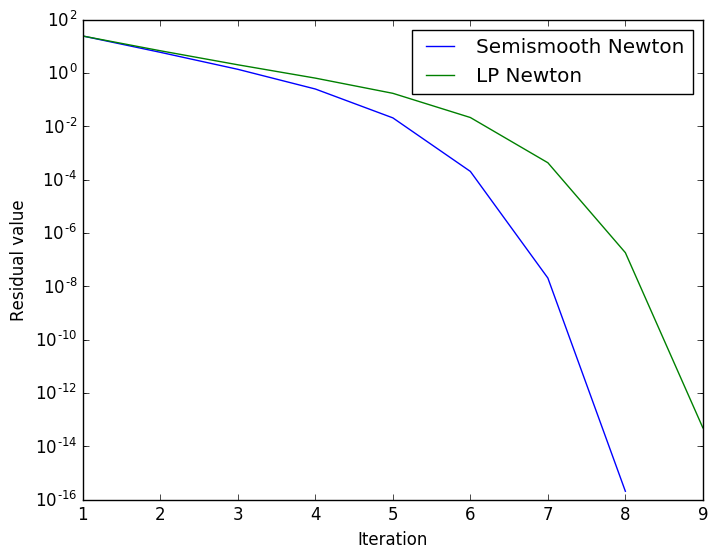

In [67]:
semilogy(SSconvdata[:,1],SSconvdata[:,2])
semilogy(LPconvdata[:,1],LPconvdata[:,2])
xlabel("Iteration");
ylabel("Residual value");
xticks(LPconvdata[:,1]);
legend(["Semismooth Newton","LP Newton"]);

So we see that both methods converge, but the LP Newton method takes slightly smaller steps away from the solution.    
     
Now let's solve the optimization problem:

In [68]:
xlow = ones(14)*-100.0; xupp = ones(14)*100.0;
x0 = [1.0,4.0,-2.0,1.0,3.0,3.0,1.0,4.0,1.0,0.0,1.0,3.0,1.0,3.0];
lpNewton(x0,p,KKTsys,50,1.0e-9,xlow,xupp);

Iter 1: ||f(x)|| = 1.0
Iter 2: ||f(x)|| = 0.5
Iter 3: ||f(x)|| = 0.3571428571428573
Iter 4: ||f(x)|| = 0.22893772893772904
Iter 5: ||f(x)|| = 0.12219135831433074
Iter 6: ||f(x)|| = 0.046341180982683916
Iter 7: ||f(x)|| = 0.008717604771980358
Iter 8: ||f(x)|| = 0.0003641122321400669
Iter 9: ||f(x)|| = 6.616839520603959e-7
Iter 10: ||f(x)|| = 2.189171242070223e-12
Solution: [4.37824e-12,1.5,-1.5,2.18905e-12,0.457875,0.457875,2.18912e-12,1.5,2.18912e-12,-2.18912e-12,2.18912e-12,0.500005,-7.58505e-17,1.09456e-11]
Residual value: [2.1891e-12,2.18917e-12,2.18915e-12,2.18914e-12,2.18912e-12,-2.18912e-12,2.18914e-12,-2.18912e-12,2.18905e-12,-2.18912e-12,2.18912e-12,2.18912e-12,-7.58505e-17,2.18912e-12]


## A chemical engineering application
The process of separating a mixture into a liquid and vapor (flashing) can be modeled with nonsmooth functions, where points of nonsmoothness represent transitions between phase regimes (all-vapor, two-phase equilibrium, all-liquid).

Here we look at flashing a 20-80 mol% ethanol-water mixture initially at atmospheric pressure and 350K and explore increasing the external heat duty of the process.

In [69]:
function PQflash{T,U}(x::Vector{T}, p::Vector{U}, y::Vector{T})
    
    z = Vector{U}(2); Psat = Vector{T}(2); K = Vector{T}(2); xliq = Vector{T}(2); yvap = Vector{T}(2);
    alpha = x[1]; ## Vapor fraction
    Temp = x[2];  ## Flash temperature, K
    Q = p[1];     ## Heat duty, W
    P = p[2];     ## Flash pressure, MPa
    z[1] = p[3];  ## Water mole fraction in feed
    z[2] = 1.0 - p[3]; 
    
    # Vapor pressure from Antoine's equation
    Psat[1] = exp(23.7836 - 3782.89/(Temp-42.85))/10^6; #K, MPa
    Psat[2] = exp(23.4776 - 3984.92/(Temp-39.72))/10^6; #K, MPa

    ## K-values from Raoult's Law
    K[1] = Psat[1]/P;
    K[2] = Psat[2]/P;

    ## Calculate vapor and liquid mole fractions
    xliq[1] = z[1]/(1.0+alpha*(K[1]-1.0));
    xliq[2] = z[2]/(1.0+alpha*(K[2]-1.0));
    yvap[1] = K[1]*xliq[1];
    yvap[2] = K[2]*xliq[2];
    
    ## Enthlpy assuming constant heat capacity and Tref = 298.15K
    hf = z[1]*(75.348*(350.0-298.15)) + z[2]*(111.46*(350.0-298.15));
    hl = xliq[1]*(75.348*(Temp-298.15)) + xliq[2]*(111.46*(Temp-298.15));
    hv = yvap[1]*(75.348*(Temp-298.15)) + yvap[2]*(111.46*(Temp-298.15));

    
    RR = (z[1]*(K[1]-1.0))/(1.0+alpha*(K[1]-1.0)) + (z[2]*(K[2]-1.0))/(1.0+alpha*(K[2]-1.0));

    y[1] = mid(alpha,alpha-1.0,-RR);
    y[2] = alpha*hv + (1.0-alpha)*hl - hf - Q;
    return;
end

PQflash (generic function with 1 method)

{#T<:Any, 1}, Array{#U<:Any, 1}, Array{#T<:Any, 1}) in module Main at In[57]:3 overwritten at In[69]:3.


In [70]:
data = Array{Real}(0,2)
for i = 0:2:1000
    initGuess = [0.5,350]; p = [i,0.101325,0.8]; xlow = [0.0,0.0]; xupp = [1.0,600];
    lpNewton(initGuess,p,PQflash,50,1.0e-9,xlow,xupp);
    data = [data; i initGuess[1]];
end

Iter 1: ||f(x)|| = 0.21421164031714607
Iter 2: ||f(x)|| = 0.14288779259095463
Iter 3: ||f(x)|| = 0.00024683967603778
Iter 4: ||f(x)|| = 7.412381819449365e-10
Solution: [0.0,350.0]
Residual value: [0.0,-7.41238e-10]
Iter 1: ||f(x)|| = 2.0
Iter 2: ||f(x)|| = 0.1902913415518738
Iter 3: ||f(x)|| = 0.15655544916353392
Iter 4: ||f(x)|| = 0.00029627112871821737
Iter 5: ||f(x)|| = 1.064108801074326e-9
Iter 6: ||f(x)|| = 9.094947017729282e-13
Solution: [0.0,350.024]
Residual value: [0.0,-9.09495e-13]
Iter 1: ||f(x)|| = 4.0
Iter 2: ||f(x)|| = 0.18949548799717642
Iter 3: ||f(x)|| = 0.15585370424832945
Iter 4: ||f(x)|| = 0.0002936235623565153
Iter 5: ||f(x)|| = 1.0440999176353216e-9
Iter 6: ||f(x)|| = 2.7284841053187847e-12
Solution: [0.0,350.048]
Residual value: [0.0,2.72848e-12]
Iter 1: ||f(x)|| = 6.0
Iter 2: ||f(x)|| = 0.1886990627717185
Iter 3: ||f(x)|| = 0.15501290072006668
Iter 4: ||f(x)|| = 0.0002904669636336621
Iter 5: ||f(x)|| = 1.0222720447927713e-9
Iter 6: ||f(x)|| = 9.094947017729282e-

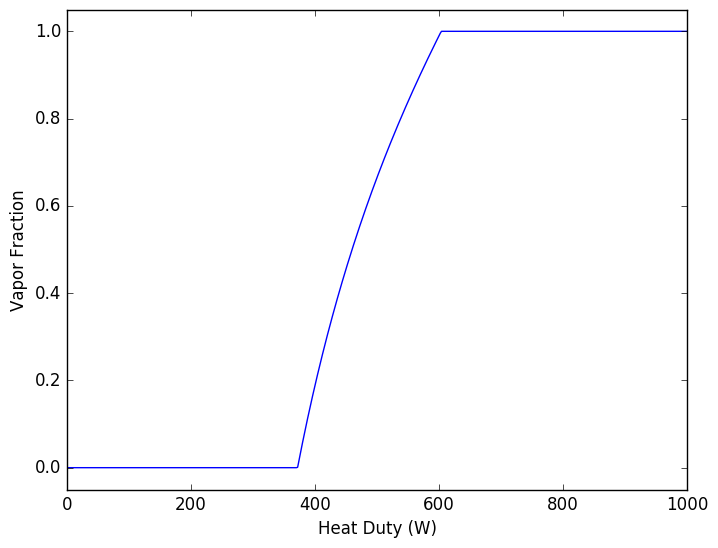

In [59]:
plot(data[:,1],data[:,2])
xlabel("Heat Duty (W)");
ylabel("Vapor Fraction");
axis([0, 1000, -0.05, 1.05]);